In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import iplot
import plotly.graph_objs as go

import tensorflow as tf

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

C:\Users\dongdai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [2]:
# create function check either a string contains number
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [5]:
# set the dataframe that we collect data
data_table = pd.DataFrame(np.zeros((1200*len(year)+100,5)),columns = ['Year','Month','Date','Yesterday_produced','Today_produced'])

In [9]:
years = []
folder_dir = "...\\product"
folder_year = os.listdir(folder_dir)
for raw_year in folder_year:
    if hasNumbers(raw_year):
        years.append(raw_year)
print(years)

['2014', '2015', '2016']


In [10]:
for y in years:
    folder_month = os.listdir(os.path.join(folder_dir,y))
    for m in folder_month:
        file_month = os.listdir(os.path.join(folder_dir,y,m))
        files_xls = [f for f in file_month if f[-3:] == 'xls']
        for xls in files_xls:
            path = os.path.join(folder_dir,y,m,xls)
            #print(path)
            month = int(re.findall(r'\d+', path)[2]) # 3 for date, 1 for month
            date = int(re.findall(r'\d+', path)[3])
            df = pd.read_excel(path, sheet_name='Sheet1')
            df.replace('NaN','NoRecords', inplace=True)
            row_index = (int(y)-int(min(year)))*1200 + month*100 + date
            data_table.iat[row_index,0] = y
            data_table.iat[row_index,1] = month
            data_table.iat[row_index,2] = date
            if df[(df.iloc[:,0]=="x1")].shape[0] == 1:
                data_table.iat[row_index,3] = df[(df.iloc[:,0]=="x1")].iloc[0,1]
                data_table.iat[row_index,4] = df[(df.iloc[:,0]=="x1")].iloc[0,2]
            else:
                data_table.iat[row_index,3] = 0
                data_table.iat[row_index,4] = 0 # 0 means no records in data

In [11]:
cleaned_data_table = data_table[data_table.Month > 0].reset_index(drop=True)

In [12]:
for i in np.arange(cleaned_data_table.shape[0]):
    if((cleaned_data_table.iloc[i,3] == 0) & (i<cleaned_data_table.shape[0])):
        j = i+1
        if cleaned_data_table.iloc[j,2] > 0:
            cleaned_data_table.iloc[i,3] = cleaned_data_table.iloc[j,2]

In [13]:
time_list = []
for i in np.arange(cleaned_data_table.shape[0]):
    t = str(int(cleaned_data_table.Year[i])) + "/" + str(int(cleaned_data_table.Month[i])) + "/" + str(int(cleaned_data_table.Date[i]))
    time_list.append(t)

In [14]:
cleaned_data_table['combined_date'] = pd.Series(time_list, index=cleaned_data_table.index)
cleaned_data_table['combined_date'] = pd.to_datetime(cleaned_data_table['combined_date'])

In [15]:
pd.set_option('display.max_rows', 1000)
cleaned_data_table.head(10)

,Year,Month,Date,Yesterday_produced,Today_produced,combined_date
0,2014.0,4.0,25.0,510.0,698.0,2014-04-25
1,2014.0,4.0,26.0,698.0,800.0,2014-04-26
2,2014.0,4.0,27.0,800.0,340.0,2014-04-27
3,2014.0,4.0,28.0,340.0,368.0,2014-04-28
4,2014.0,4.0,29.0,368.0,218.0,2014-04-29
5,2014.0,4.0,30.0,218.0,348.0,2014-04-30
6,2014.0,5.0,1.0,348.0,164.0,2014-05-01
7,2014.0,5.0,2.0,164.0,141.0,2014-05-02
8,2014.0,5.0,3.0,141.0,246.0,2014-05-03
9,2014.0,5.0,4.0,246.0,247.0,2014-05-04


In [16]:
cleaned_data_table[(cleaned_data_table.Today_produced < 50) | (cleaned_data_table.Today_produced.isnull())]

,Year,Month,Date,Yesterday_produced,Today_produced,combined_date
104,2014.0,8.0,7.0,8.0,0.0,2014-08-07
117,2014.0,8.0,20.0,21.0,0.0,2014-08-20
124,2014.0,8.0,27.0,377.0,NaN,2014-08-27
295,2015.0,2.0,16.0,17.0,0.0,2015-02-16
296,2015.0,2.0,17.0,18.0,0.0,2015-02-17
324,2015.0,3.0,17.0,18.0,0.0,2015-03-17
513,2015.0,9.0,22.0,23.0,0.0,2015-09-22
711,2016.0,4.0,7.0,8.0,0.0,2016-04-07


In [17]:
mess_index = cleaned_data_table[(cleaned_data_table.Today_produced < 50) | (cleaned_data_table.Today_produced.isnull())].index.tolist()

In [18]:
[x+1 for x in mess_index]

[105, 118, 125, 296, 297, 325, 514, 712]

In [19]:
review_ind = [x+1 for x in mess_index] + mess_index + [x-1 for x in mess_index]

In [20]:
sort_ind = sorted(list(set(review_ind)), key=int)

In [21]:
cleaned_data_table.iloc[sort_ind]

,Year,Month,Date,Yesterday_produced,Today_produced,combined_date
103,2014.0,8.0,6.0,188.0,254.0,2014-08-06
104,2014.0,8.0,7.0,8.0,0.0,2014-08-07
105,2014.0,8.0,8.0,153.0,208.0,2014-08-08
116,2014.0,8.0,19.0,190.0,234.0,2014-08-19
117,2014.0,8.0,20.0,21.0,0.0,2014-08-20
118,2014.0,8.0,21.0,479.0,556.0,2014-08-21
123,2014.0,8.0,26.0,481.0,377.0,2014-08-26
124,2014.0,8.0,27.0,377.0,NaN,2014-08-27
125,2014.0,8.0,28.0,389.0,385.0,2014-08-28
294,2015.0,2.0,15.0,1699.0,1748.0,2015-02-15


In [22]:
cleaned_data_table.Yesterday_produced[104+1]

153.0

In [23]:
for i in mess_index:
    if (cleaned_data_table.Yesterday_produced[i+1] > 50):
        cleaned_data_table.Today_produced[i] = cleaned_data_table.Yesterday_produced[i+1]

In [26]:
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(version)

trace = go.Scatter(
    x = cleaned_data_table['combined_date'][300:],
    y = cleaned_data_table['Today_produced'][300:], 
)


fig = {
    'data': [trace],
}

layout = go.Layout(
        yaxis=dict(
            range=[0, 800]
        )
    )

iplot(fig)

<module 'plotly.version' from 'C:\\Users\\dongdai\\Anaconda3\\lib\\site-packages\\plotly\\version.py'>


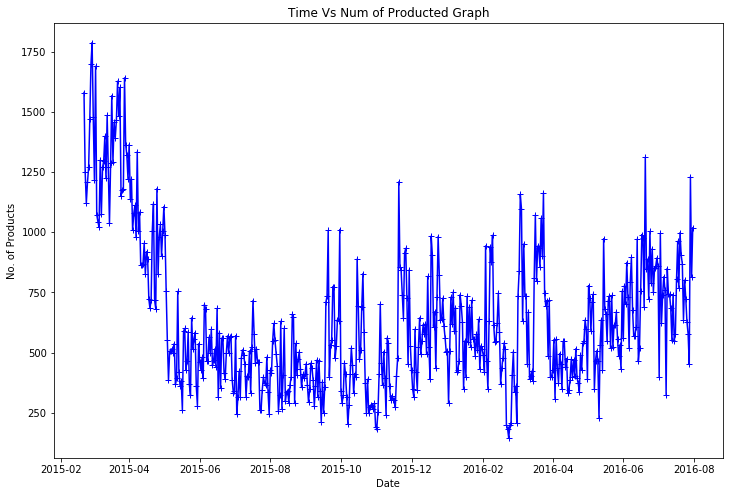

In [27]:
TITLE = 'Time Vs Num of Producted Graph'

X_AXIS_NAME = 'Date'
Y_AXIS_NAME = 'No. of Products'

time_stamp = cleaned_data_table.iloc[300:,5]

products = cleaned_data_table.iloc[300:,4]

plt.figure(figsize=(12,8))
#fig, ax = plt.subplots()
plt.plot(time_stamp, products,"b-+")
plt.xlabel(X_AXIS_NAME)
plt.ylabel(Y_AXIS_NAME)
plt.title(TITLE)
plt.show()

## Using ARMA model
https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [73]:
import itertools
import statsmodels.api as sm
# Get the raw data values from the pandas data frame.
TS = np.array(cleaned_data_table.Today_produced).reshape(-1,1)

In [74]:
# Using 90% of data for training, 10% for validation.
TRAIN_SIZE = 0.9

train_size = int(len(cleaned_data_table) * TRAIN_SIZE)
test_size = len(cleaned_data_table) - train_size
train, test = TS[0:train_size, :], TS[train_size:len(cleaned_data_table), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (744, 83)


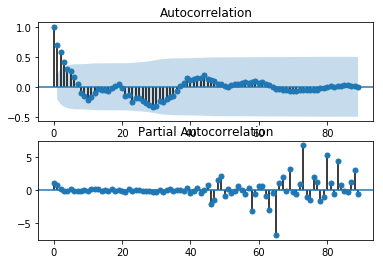

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(TS[650:740], ax=plt.gca())
plt.subplot(212)
plot_pacf(TS[650:740], ax=plt.gca())
plt.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  827
Model:                     ARMA(4, 0)   Log Likelihood               -5466.503
Method:                       css-mle   S.D. of innovations            179.467
Date:                Tue, 29 Jan 2019   AIC                          10945.006
Time:                        12:05:00   BIC                          10973.312
Sample:                             0   HQIC                         10955.863
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        655.1639     97.301      6.733      0.000     464.457     845.871
ar.L1.y        0.4159      0.034     12.122      0.000       0.349       0.483
ar.L2.y        0.2369      0.037      6.396      0.0

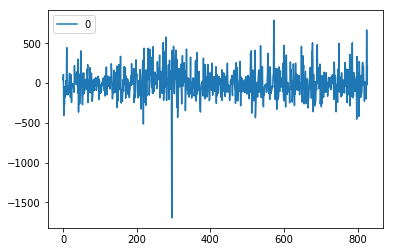

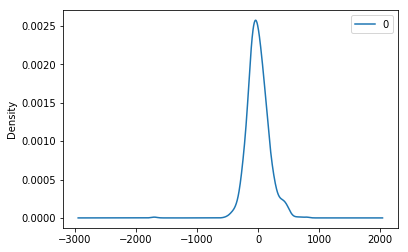

                 0
count   827.000000
mean     -0.029086
std     179.628090
min   -1697.254784
25%    -106.769288
50%     -16.697249
75%      93.660482
max     792.406890


In [31]:
# based on the ACF and PACF, we better use AR(4) model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(TS, order=(4,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [32]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 8)
d = range(0, 2)
q = range(0, 8)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
#seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
for i in pdq[:10]:
    print('SARIMAX: {}'.format(i))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 0)
SARIMAX: (0, 0, 1)
SARIMAX: (0, 0, 2)
SARIMAX: (0, 0, 3)
SARIMAX: (0, 0, 4)
SARIMAX: (0, 0, 5)
SARIMAX: (0, 0, 6)
SARIMAX: (0, 0, 7)
SARIMAX: (0, 1, 0)
SARIMAX: (0, 1, 1)


In [33]:
warnings.filterwarnings("ignore")
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(train,
                                        seasonal_order=(0, 0, 0, 0),
                                        order=param,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{} - AIC:{:.2f}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:11952.54
ARIMA(0, 0, 1) - AIC:11251.19
ARIMA(0, 0, 2) - AIC:10829.36
ARIMA(0, 0, 3) - AIC:10605.03
ARIMA(0, 0, 4) - AIC:10482.01
ARIMA(0, 0, 5) - AIC:10317.01
ARIMA(0, 0, 6) - AIC:10223.51
ARIMA(0, 0, 7) - AIC:10137.69
ARIMA(0, 1, 0) - AIC:10002.14
ARIMA(0, 1, 1) - AIC:9782.73
ARIMA(0, 1, 2) - AIC:9765.50
ARIMA(0, 1, 3) - AIC:9752.02
ARIMA(0, 1, 4) - AIC:9741.09
ARIMA(0, 1, 5) - AIC:9728.02
ARIMA(0, 1, 6) - AIC:9717.86
ARIMA(0, 1, 7) - AIC:9704.00
ARIMA(1, 0, 0) - AIC:10002.85
ARIMA(1, 0, 1) - AIC:9800.48
ARIMA(1, 0, 2) - AIC:9779.00
ARIMA(1, 0, 3) - AIC:9766.18
ARIMA(1, 0, 4) - AIC:9755.21
ARIMA(1, 0, 5) - AIC:9742.65
ARIMA(1, 0, 6) - AIC:9731.77
ARIMA(1, 0, 7) - AIC:9718.21
ARIMA(1, 1, 0) - AIC:9868.79
ARIMA(1, 1, 1) - AIC:9778.70
ARIMA(1, 1, 2) - AIC:9763.13
ARIMA(1, 1, 3) - AIC:9754.31
ARIMA(1, 1, 4) - AIC:9743.48
ARIMA(1, 1, 5) - AIC:9730.00
ARIMA(1, 1, 6) - AIC:9719.60
ARIMA(1, 1, 7) - AIC:9703.98
ARIMA(2, 0, 0) - AIC:9864.59
ARIMA(2, 0, 1) - AIC:9797.60
ARIM

In [228]:
## based on the tuning parameter search, the ARIMA(4,1,0) seems the best fit.
## fit the model
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(4,1,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5507      0.028    -19.594      0.000      -0.606      -0.496
ar.L2         -0.3307      0.038     -8.596      0.000      -0.406      -0.255
ar.L3         -0.2151      0.042     -5.121      0.000      -0.297      -0.133
ar.L4         -0.0823      0.030     -2.724      0.006      -0.142      -0.023
sigma2      3.176e+04    629.907     50.413      0.000    3.05e+04     3.3e+04


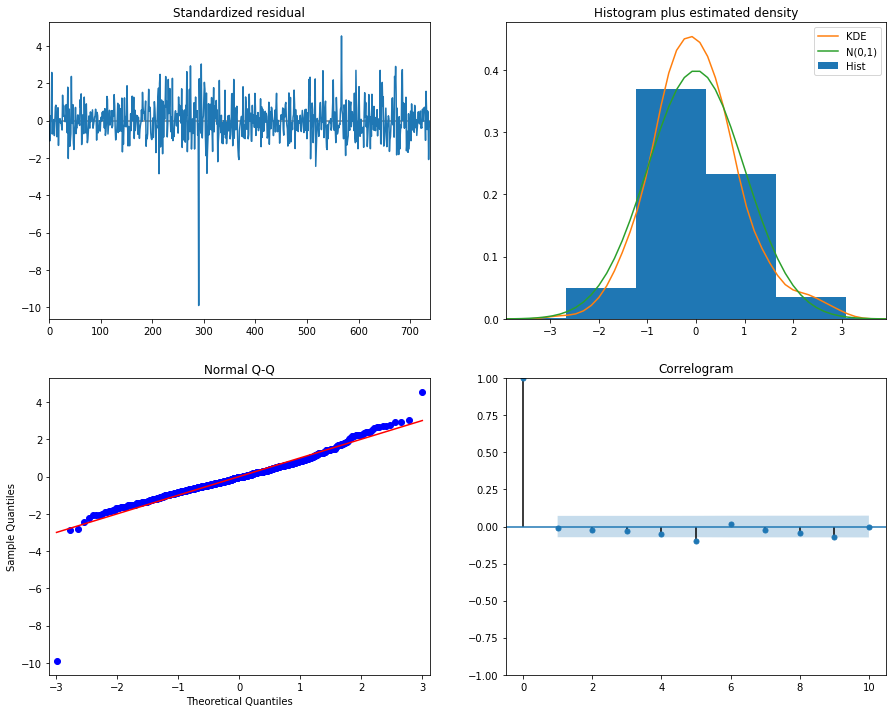

In [229]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [76]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(train, start_p=0, max_p=0,
                            d=1,
                            start_q=1,max_q=1,
                            error_action='ignore')
print(stepwise_model.aic())

9815.351946107228


In [239]:
step_size = 21
arma_pred = []
for i in range(62):
    ind = 744 + i + 1
    mod_temp = sm.tsa.statespace.SARIMAX(TS[ind:ind + step_size],order=(4,1,0),enforce_stationarity=False,enforce_invertibility=False)
    arma_pred.append(float(mod_temp.fit().get_forecast(steps=1).predicted_mean))

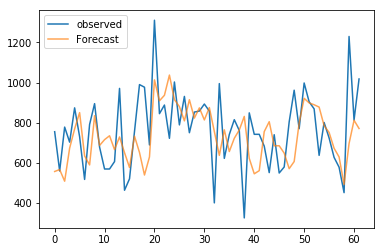

In [241]:
plt.plot(test[window_size:],label='observed')
plt.plot(arma_pred,label='Forecast by ARIMA', alpha=.7)
plt.legend()

plt.show()

In [248]:
# a different method
from pyramid.arima import auto_arima
stepwise_model = auto_arima(train, d=1,
                            start_p=4, max_p=7,
                            start_q=4,max_q=7,
                            error_action='ignore')
print(stepwise_model.aic())

9807.619733922738


In [249]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend='c')

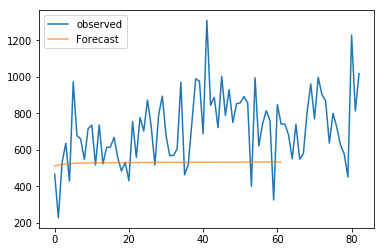

In [251]:
plt.plot(test,label='observed')
plt.plot(future_forecast,label='Forecast', alpha=.7)
plt.legend()

plt.show()

## Fit the RNN model using tensorflow

In [37]:
# Get the raw data values from the pandas data frame.
TS = np.array(cleaned_data_table.Today_produced).reshape(-1,1)

In [38]:
# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
TS_scaled = scaler.fit_transform(TS)

# Print a few values.
TS_scaled[0:5]

array([[0.32465116],
       [0.37209302],
       [0.15813953],
       [0.17116279],
       [0.10139535]])

In [39]:
# Using 90% of data for training, 40% for validation.
TRAIN_SIZE = 0.9

train_size = int(len(cleaned_data_table) * TRAIN_SIZE)
test_size = len(cleaned_data_table) - train_size
train, test = TS_scaled[0:train_size, :], TS_scaled[train_size:len(cleaned_data_table), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (744, 83)


In [40]:
def create_dataset(dataset, window_size = 21):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        data_X.append(dataset[(i + 1):(i + window_size + 1), 0])
        data_Y.append(dataset[(i + 2):(i + window_size + 2), 0])
    return(np.array(data_X), np.array(data_Y))

In [41]:
# Create test and training sets for one-step-ahead regression.
window_size = 21
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
train_Y = np.reshape(train_Y, (train_Y.shape[0], train_Y.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
test_Y = np.reshape(test_Y, (test_Y.shape[0], test_Y.shape[1], 1))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(722, 21)
New training data shape:
(722, 21, 1)


In [42]:
tf.reset_default_graph()

window_size =21
inputs = 1
hidden = 20
output = 1

X = tf.placeholder(tf.float32, [None, window_size,inputs])
y = tf.placeholder(tf.float32, [None, window_size,output])

LSTM_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(LSTM_cell, X, dtype=tf.float32)

learning_rate = 0.005

stacked_rnn_output = tf.reshape(rnn_output, [-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, window_size, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [43]:
n_iterations = 1501

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        sess.run(training_op, feed_dict={X: train_X, y: train_Y})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: train_X, y: train_Y})
            print(iteration, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: test_X})
    y_train = sess.run(outputs, feed_dict={X: train_X})

0 	MSE: 1205.3848
100 	MSE: 138.10558
200 	MSE: 112.24955
300 	MSE: 108.44976
400 	MSE: 106.215904
500 	MSE: 103.87562
600 	MSE: 101.905624
700 	MSE: 101.35425
800 	MSE: 100.969955
900 	MSE: 100.65256
1000 	MSE: 100.327805
1100 	MSE: 100.00705
1200 	MSE: 99.712265
1300 	MSE: 99.44071
1400 	MSE: 99.26518
1500 	MSE: 99.509285


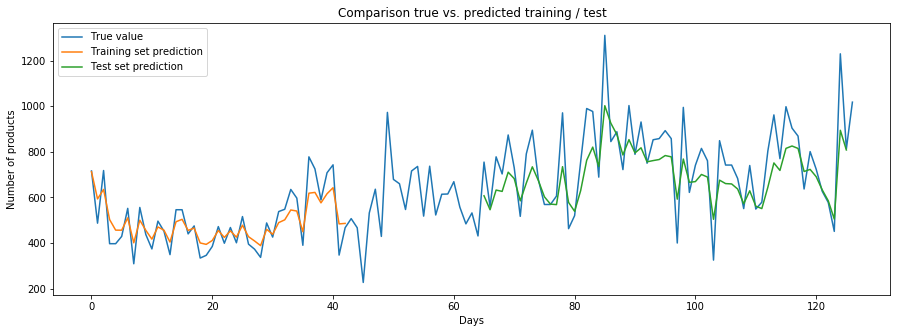

In [45]:
# Start with training predictions.
tf_train_predict_plot = np.empty_like(TS_scaled)
tf_train_predict_plot[:, :] = np.nan
tf_train_predict_plot[window_size:len(y_train) + window_size, :] = scaler.inverse_transform(y_train[:,(window_size-1)])

# Add test predictions.
tf_test_predict_plot = np.empty_like(TS_scaled)
tf_test_predict_plot[:, :] = np.nan
tf_test_predict_plot[len(y_train) + 1 + (window_size * 2):len(TS_scaled) - 1, :] = scaler.inverse_transform(y_pred[:,(window_size-1)])

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(TS_scaled)[700:], label = "True value")
plt.plot(tf_train_predict_plot[700:], label = "Training set prediction")
plt.plot(tf_test_predict_plot[700:], label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Number of products")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

## Try the similar work with keras
https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

In [135]:
# Get the raw data values from the pandas data frame.
TS = np.array(cleaned_data_table.Today_produced).reshape(-1,1)

In [136]:
# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
TS_scaled = scaler.fit_transform(TS)

# Print a few values.
TS_scaled[0:5]

array([[0.32465116],
       [0.37209302],
       [0.15813953],
       [0.17116279],
       [0.10139535]])

In [137]:
# Using 90% of data for training, 10% for validation.
TRAIN_SIZE = 0.90

train_size = int(len(TS_scaled) * TRAIN_SIZE)
test_size = len(TS_scaled) - train_size
train, test = TS_scaled[0:train_size, :], TS_scaled[train_size:len(TS_scaled), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (744, 83)


In [57]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [58]:
# Create test and training sets for one-step-ahead regression.
window_size = 21
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(723, 21)
New training data shape:
(723, 1, 21)


In [59]:
def fit_model(train_X, train_Y, window_size):
    model = Sequential()
    
    model.add(LSTM(20, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 15, 
              batch_size = 10, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model_keras = fit_model(train_X, train_Y, window_size)

Epoch 1/15
 - 1s - loss: 0.0128
Epoch 2/15
 - 0s - loss: 0.0084
Epoch 3/15
 - 0s - loss: 0.0082
Epoch 4/15
 - 0s - loss: 0.0079
Epoch 5/15
 - 0s - loss: 0.0077
Epoch 6/15
 - 0s - loss: 0.0076
Epoch 7/15
 - 0s - loss: 0.0077
Epoch 8/15
 - 0s - loss: 0.0073
Epoch 9/15
 - 0s - loss: 0.0073
Epoch 10/15
 - 0s - loss: 0.0070
Epoch 11/15
 - 0s - loss: 0.0071
Epoch 12/15
 - 0s - loss: 0.0070
Epoch 13/15
 - 0s - loss: 0.0078
Epoch 14/15
 - 0s - loss: 0.0069
Epoch 15/15
 - 0s - loss: 0.0069


In [60]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model_keras, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model_keras, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 177.28 RMSE
Test data score: 201.63 RMSE


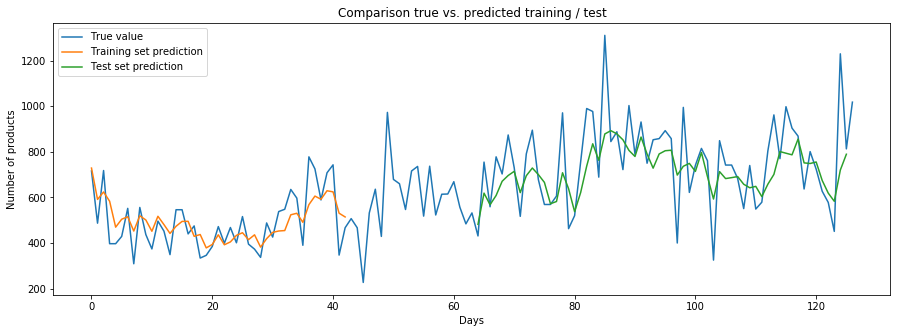

In [66]:
# Start with training predictions.
keras_train_predict_plot = np.empty_like(TS_scaled)
keras_train_predict_plot[:, :] = np.nan
keras_train_predict_plot[window_size - 1 :len(train_predict) - 1 + window_size, :] = train_predict

# Add test predictions.
keras_test_predict_plot = np.empty_like(TS_scaled)
keras_test_predict_plot[:, :] = np.nan
keras_test_predict_plot[len(train_predict)+(window_size * 2) -1 :len(TS_scaled)-1 , :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(TS_scaled)[700:], label = "True value")
plt.plot(keras_train_predict_plot[700:], label = "Training set prediction")
plt.plot(keras_test_predict_plot[700:], label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Number of products")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

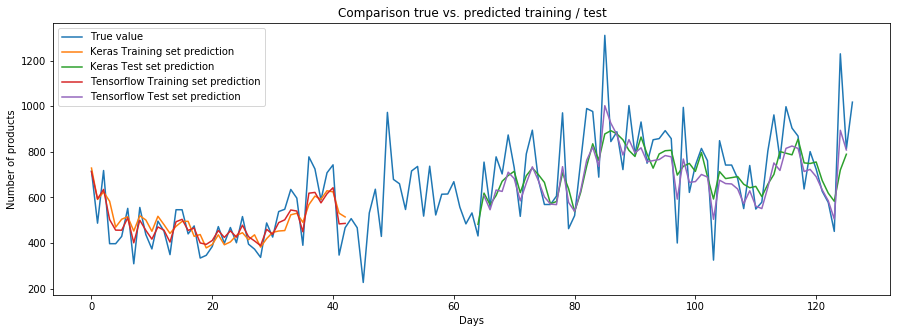

In [67]:
# comparing the two methods
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(TS_scaled)[700:], label = "True value")
plt.plot(keras_train_predict_plot[700:], label = "Keras Training set prediction")
plt.plot(keras_test_predict_plot[700:], label = "Keras Test set prediction")
plt.plot(tf_train_predict_plot[700:], label = "Tensorflow Training set prediction")
plt.plot(tf_test_predict_plot[700:], label = "Tensorflow Test set prediction")
plt.xlabel("Days")
plt.ylabel("Number of products")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()